In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# **Imports**

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

import time
import gc

import nndl.utils as utils
import nndl.models.cnn as cnn
import nndl.models.cgru as cgru
import nndl.models.clstm as clstm
import nndl.models.ctransformer as ctransformer
import nndl.models.gru as gru
import nndl.models.llstm as llstm

In [5]:
import random
torch.manual_seed(1337)
np.random.seed(1337)
random.seed(1337)

In [6]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


# **Load data from localhost**

In [7]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


# **Define Data Prep**

In [8]:
def data_prep(X,y,sub_sample,average,noise,clippings,channel_dropout=0,time_reverse=0):

    total_X = None
    total_y = None
    X = X[:,:,0:clippings]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if time_reverse != 0:
        mask = (torch.rand(total_X.shape[0]) >= time_reverse)
        X_reverse = torch.flip((total_X[mask]), [2])
        total_X = torch.cat((total_X, X_reverse))
        total_y = torch.cat((total_y, total_y[mask]))

        print(f'Shape of X after reverse {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')


    return total_X,total_y

def test_data_prep(X, clipping=800, sub_sample=2):

    total_X = None

    X = X[:,:,0:clipping]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)

    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

# **Split Data**

In [9]:
input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 1e-4
batch_size = 200
num_epochs = 100
number_epochs = num_epochs
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
channel_dropout = 0.2
time_reverse = 0
noise = True

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
#print(indices)
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
#print(split_idx)
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

SOME torch.Size([2115, 22, 1000])


In [10]:
# update number of epochs
# change path to save
number_epochs = 50
# path_to_save = '/content/drive/MyDrive/project_data/'
path_to_save = './question3/'
super_start_time = time.time()

In [11]:
def calc_time(end_time, start_time):
  hours = (end_time - super_start_time) // 3600
  minutes = ((end_time - super_start_time) % 3600) // 60
  seconds = (end_time - super_start_time) % 60

  print(f'time to train model: \
  {hours} hours, \
  {minutes} minutes, \
  {int(seconds)} seconds')

# **Party (hopefully)**

### CNN-Transformer - 200

In [12]:
print('Prepping Training Data')
X_train1, y_train1 = data_prep(X_train, y_train, subsample, average, noise, 200)
print('\nPrepping Validation Data')
X_valid1, y_valid1 = data_prep(X_valid, y_valid, subsample, average, noise, 200)
print('\nPrepping Test Data')
X_test1 = test_data_prep(X_test, 200, subsample)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train1.shape)
print('Final shape of validation set:', X_valid1.shape)
print('Final shape of test set:', X_test1.shape)

train_loader = DataLoader(TensorDataset(X_train1, y_train1), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid1, y_valid1), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test1, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

Prepping Training Data
Shape of X after trimming: torch.Size([1903, 22, 200])
Shape of X after maxpooling: torch.Size([1903, 22, 100])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 100])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 100])
Shape of Y: torch.Size([7612])

Prepping Validation Data
Shape of X after trimming: torch.Size([212, 22, 200])
Shape of X after maxpooling: torch.Size([212, 22, 100])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 100])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 100])
Shape of Y: torch.Size([848])

Prepping Test Data
Shape of X after trimming: torch.Size([443, 22, 200])
Shape of X after maxpooling: torch.Size([443, 22, 100])

FINISHED PREP

Final shape of training set: torch.Size(

### CNN-Transformer - 200

In [13]:
torchinfo.summary(ctransformer.CTransformer(time_bins=200), input_size=(batch_size, 22, 200))

Layer (type:depth-idx)                        Output Shape              Param #
CTransformer                                  [200, 4]                  --
├─Sequential: 1-1                             [200, 25, 196]            --
│    └─Conv1d: 2-1                            [200, 25, 196]            2,775
│    └─ReLU: 2-2                              [200, 25, 196]            --
│    └─BatchNorm1d: 2-3                       [200, 25, 196]            50
│    └─Dropout: 2-4                           [200, 25, 196]            --
├─Sequential: 1-2                             [200, 200, 1, 57]         --
│    └─Conv2d: 2-5                            [200, 200, 1, 172]        125,200
│    └─ELU: 2-6                               [200, 200, 1, 172]        --
│    └─BatchNorm2d: 2-7                       [200, 200, 1, 172]        400
│    └─MaxPool2d: 2-8                         [200, 200, 1, 57]         --
│    └─Dropout: 2-9                           [200, 200, 1, 57]         --
├─Positiona

In [14]:
ctransformer_model = ctransformer.CTransformer(time_bins=200).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ctransformer_model.parameters(),
                              lr=0.001767340543208569,
                              betas=(0.9,0.999),
                              weight_decay=0.008272087903010924,
                              eps=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

In [16]:
start_time = time.time()
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=ctransformer_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=number_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.312, Train loss: 1.431
Val acc: 0.329, Val loss: 1.409

Epoch 2


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.413, Train loss: 1.264
Val acc: 0.450, Val loss: 1.234

Epoch 3


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.506, Train loss: 1.152
Val acc: 0.467, Val loss: 1.399

Epoch 4


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.517, Train loss: 1.114
Val acc: 0.529, Val loss: 1.255

Epoch 5


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.569, Train loss: 1.034
Val acc: 0.560, Val loss: 1.121

Epoch 6


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.601, Train loss: 0.956
Val acc: 0.581, Val loss: 1.169

Epoch 7


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.648, Train loss: 0.866
Val acc: 0.587, Val loss: 1.055

Epoch 8


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.652, Train loss: 0.847
Val acc: 0.583, Val loss: 1.246

Epoch 9


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.689, Train loss: 0.772
Val acc: 0.613, Val loss: 1.095

Epoch 10


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.725, Train loss: 0.696
Val acc: 0.580, Val loss: 1.208

Epoch 11


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.735, Train loss: 0.673
Val acc: 0.586, Val loss: 1.170

Epoch 12


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.757, Train loss: 0.613
Val acc: 0.620, Val loss: 1.094

Epoch 13


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.782, Train loss: 0.561
Val acc: 0.575, Val loss: 1.251

Epoch 14


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.799, Train loss: 0.519
Val acc: 0.599, Val loss: 1.195

Epoch 15


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.819, Train loss: 0.466
Val acc: 0.618, Val loss: 1.220

Epoch 16


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.838, Train loss: 0.426
Val acc: 0.625, Val loss: 1.187

Epoch 17


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.847, Train loss: 0.402
Val acc: 0.614, Val loss: 1.224

Epoch 18


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.862, Train loss: 0.362
Val acc: 0.625, Val loss: 1.286

Epoch 19


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.874, Train loss: 0.318
Val acc: 0.603, Val loss: 1.353

Epoch 20


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.882, Train loss: 0.311
Val acc: 0.624, Val loss: 1.323

Epoch 21


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.894, Train loss: 0.279
Val acc: 0.617, Val loss: 1.380

Epoch 22


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.899, Train loss: 0.271
Val acc: 0.632, Val loss: 1.363

Epoch 23


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.903, Train loss: 0.262
Val acc: 0.630, Val loss: 1.383

Epoch 24


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.908, Train loss: 0.243
Val acc: 0.634, Val loss: 1.376

Epoch 25


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.906, Train loss: 0.251
Val acc: 0.634, Val loss: 1.380

Epoch 26


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.905, Train loss: 0.249
Val acc: 0.636, Val loss: 1.359

Epoch 27


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.909, Train loss: 0.244
Val acc: 0.634, Val loss: 1.364

Epoch 28


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.912, Train loss: 0.238
Val acc: 0.639, Val loss: 1.369

Epoch 29


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.910, Train loss: 0.237
Val acc: 0.639, Val loss: 1.375

Epoch 30


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.907, Train loss: 0.250
Val acc: 0.618, Val loss: 1.426

Epoch 31


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.911, Train loss: 0.238
Val acc: 0.631, Val loss: 1.426

Epoch 32


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.908, Train loss: 0.252
Val acc: 0.623, Val loss: 1.453

Epoch 33


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.908, Train loss: 0.243
Val acc: 0.626, Val loss: 1.445

Epoch 34


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.900, Train loss: 0.272
Val acc: 0.612, Val loss: 1.572

Epoch 35


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.897, Train loss: 0.276
Val acc: 0.604, Val loss: 1.474

Epoch 36


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.901, Train loss: 0.260
Val acc: 0.604, Val loss: 1.561

Epoch 37


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.894, Train loss: 0.283
Val acc: 0.593, Val loss: 1.651

Epoch 38


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.881, Train loss: 0.314
Val acc: 0.605, Val loss: 1.486

Epoch 39


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.876, Train loss: 0.326
Val acc: 0.603, Val loss: 1.683

Epoch 40


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.879, Train loss: 0.327
Val acc: 0.606, Val loss: 1.468

Epoch 41


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.891, Train loss: 0.297
Val acc: 0.587, Val loss: 1.563

Epoch 42


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.858, Train loss: 0.382
Val acc: 0.632, Val loss: 1.530

Epoch 43


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.874, Train loss: 0.328
Val acc: 0.611, Val loss: 1.558

Epoch 44


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.881, Train loss: 0.317
Val acc: 0.594, Val loss: 1.542

Epoch 45


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.896, Train loss: 0.281
Val acc: 0.534, Val loss: 1.983

Epoch 46


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.856, Train loss: 0.393
Val acc: 0.526, Val loss: 1.739

Epoch 47


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.848, Train loss: 0.409
Val acc: 0.611, Val loss: 1.445

Epoch 48


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.828, Train loss: 0.454
Val acc: 0.610, Val loss: 1.393

Epoch 49


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.832, Train loss: 0.449
Val acc: 0.575, Val loss: 1.420

Epoch 50


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.832, Train loss: 0.437
Val acc: 0.586, Val loss: 1.562



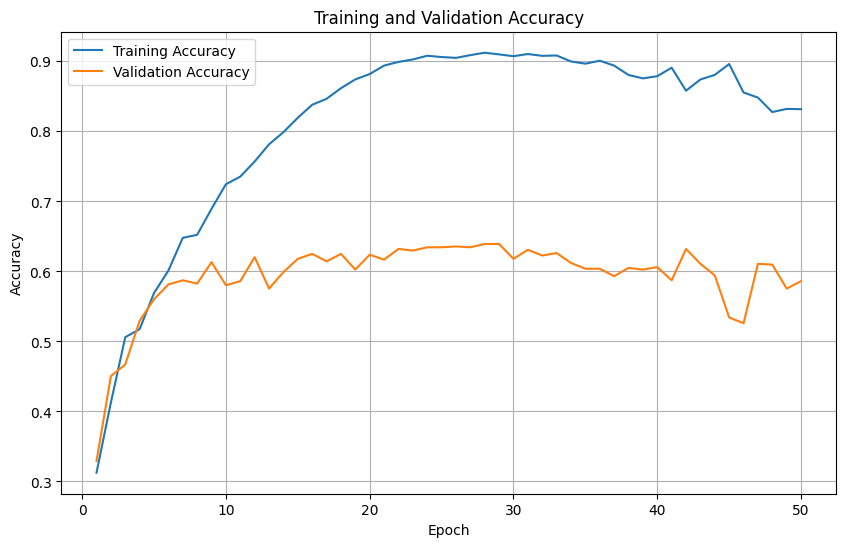

In [17]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
end_time = time.time()
calc_time(end_time, start_time)
utils.test_model(ctransformer_model, test_loader)

time to train model:   0.0 hours,   1.0 minutes,   31 seconds
Test acc: 0.582


In [19]:
torch.save(ctransformer_model, path_to_save+'ctransformer-200')
torch.cuda.empty_cache()
ctransformer_model.to('cpu')
del ctransformer_model
gc.collect()

3633

### Data prep - 400

In [20]:
print('Prepping Training Data')
X_train2, y_train2 = data_prep(X_train, y_train, subsample, average, noise, 400)
print('\nPrepping Validation Data')
X_valid2, y_valid2 = data_prep(X_valid, y_valid, subsample, average, noise, 400)
print('\nPrepping Test Data')
X_test2 = test_data_prep(X_test, 400)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train2.shape)
print('Final shape of validation set:', X_valid2.shape)
print('Final shape of test set:', X_test2.shape)

train_loader = DataLoader(TensorDataset(X_train2, y_train2), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid2, y_valid2), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test2, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

Prepping Training Data
Shape of X after trimming: torch.Size([1903, 22, 400])
Shape of X after maxpooling: torch.Size([1903, 22, 200])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 200])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 200])
Shape of Y: torch.Size([7612])

Prepping Validation Data
Shape of X after trimming: torch.Size([212, 22, 400])
Shape of X after maxpooling: torch.Size([212, 22, 200])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 200])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 200])
Shape of Y: torch.Size([848])

Prepping Test Data
Shape of X after trimming: torch.Size([443, 22, 400])
Shape of X after maxpooling: torch.Size([443, 22, 200])

FINISHED PREP

Final shape of training set: torch.Size(

### CNN-Transformer - 400

In [21]:
torchinfo.summary(ctransformer.CTransformer(time_bins=400), input_size=(batch_size, 22, 200))

Layer (type:depth-idx)                        Output Shape              Param #
CTransformer                                  [200, 4]                  --
├─Sequential: 1-1                             [200, 25, 196]            --
│    └─Conv1d: 2-1                            [200, 25, 196]            2,775
│    └─ReLU: 2-2                              [200, 25, 196]            --
│    └─BatchNorm1d: 2-3                       [200, 25, 196]            50
│    └─Dropout: 2-4                           [200, 25, 196]            --
├─Sequential: 1-2                             [200, 200, 1, 57]         --
│    └─Conv2d: 2-5                            [200, 200, 1, 172]        125,200
│    └─ELU: 2-6                               [200, 200, 1, 172]        --
│    └─BatchNorm2d: 2-7                       [200, 200, 1, 172]        400
│    └─MaxPool2d: 2-8                         [200, 200, 1, 57]         --
│    └─Dropout: 2-9                           [200, 200, 1, 57]         --
├─Positiona

In [22]:
ctransformer_model = ctransformer.CTransformer(time_bins=400).to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ctransformer_model.parameters(),
                              lr=0.001767340543208569,
                              betas=(0.9,0.999),
                              weight_decay=0.008272087903010924,
                              eps=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

In [24]:
start_time = time.time()
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=ctransformer_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=number_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.290, Train loss: 1.491
Val acc: 0.406, Val loss: 1.352

Epoch 2


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.427, Train loss: 1.240
Val acc: 0.465, Val loss: 1.343

Epoch 3


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.506, Train loss: 1.120
Val acc: 0.463, Val loss: 1.300

Epoch 4


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.558, Train loss: 1.034
Val acc: 0.522, Val loss: 1.237

Epoch 5


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.615, Train loss: 0.938
Val acc: 0.539, Val loss: 1.266

Epoch 6


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.657, Train loss: 0.842
Val acc: 0.629, Val loss: 1.061

Epoch 7


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.682, Train loss: 0.782
Val acc: 0.590, Val loss: 1.206

Epoch 8


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.708, Train loss: 0.723
Val acc: 0.485, Val loss: 1.680

Epoch 9


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.730, Train loss: 0.679
Val acc: 0.654, Val loss: 1.076

Epoch 10


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.773, Train loss: 0.570
Val acc: 0.683, Val loss: 1.026

Epoch 11


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.800, Train loss: 0.509
Val acc: 0.590, Val loss: 1.419

Epoch 12


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.784, Train loss: 0.568
Val acc: 0.671, Val loss: 0.988

Epoch 13


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.841, Train loss: 0.415
Val acc: 0.696, Val loss: 1.058

Epoch 14


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.850, Train loss: 0.386
Val acc: 0.703, Val loss: 1.012

Epoch 15


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.869, Train loss: 0.345
Val acc: 0.676, Val loss: 1.115

Epoch 16


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.872, Train loss: 0.332
Val acc: 0.697, Val loss: 1.061

Epoch 17


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.897, Train loss: 0.268
Val acc: 0.708, Val loss: 1.085

Epoch 18


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.900, Train loss: 0.265
Val acc: 0.696, Val loss: 1.129

Epoch 19


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.916, Train loss: 0.232
Val acc: 0.718, Val loss: 1.119

Epoch 20


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.923, Train loss: 0.213
Val acc: 0.722, Val loss: 1.125

Epoch 21


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.933, Train loss: 0.182
Val acc: 0.723, Val loss: 1.149

Epoch 22


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.939, Train loss: 0.163
Val acc: 0.719, Val loss: 1.154

Epoch 23


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.943, Train loss: 0.161
Val acc: 0.711, Val loss: 1.156

Epoch 24


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.940, Train loss: 0.166
Val acc: 0.717, Val loss: 1.164

Epoch 25


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.939, Train loss: 0.161
Val acc: 0.719, Val loss: 1.157

Epoch 26


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.944, Train loss: 0.156
Val acc: 0.722, Val loss: 1.154

Epoch 27


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.941, Train loss: 0.163
Val acc: 0.717, Val loss: 1.146

Epoch 28


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.945, Train loss: 0.153
Val acc: 0.730, Val loss: 1.151

Epoch 29


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.943, Train loss: 0.160
Val acc: 0.709, Val loss: 1.153

Epoch 30


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.943, Train loss: 0.164
Val acc: 0.719, Val loss: 1.145

Epoch 31


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.939, Train loss: 0.168
Val acc: 0.716, Val loss: 1.195

Epoch 32


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.938, Train loss: 0.159
Val acc: 0.721, Val loss: 1.136

Epoch 33


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.940, Train loss: 0.159
Val acc: 0.713, Val loss: 1.276

Epoch 34


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.942, Train loss: 0.158
Val acc: 0.708, Val loss: 1.310

Epoch 35


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.936, Train loss: 0.184
Val acc: 0.724, Val loss: 1.206

Epoch 36


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.938, Train loss: 0.178
Val acc: 0.691, Val loss: 1.302

Epoch 37


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.918, Train loss: 0.224
Val acc: 0.695, Val loss: 1.289

Epoch 38


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.912, Train loss: 0.239
Val acc: 0.682, Val loss: 1.279

Epoch 39


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.923, Train loss: 0.208
Val acc: 0.708, Val loss: 1.331

Epoch 40


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.914, Train loss: 0.224
Val acc: 0.675, Val loss: 1.500

Epoch 41


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.893, Train loss: 0.284
Val acc: 0.651, Val loss: 1.399

Epoch 42


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.895, Train loss: 0.284
Val acc: 0.652, Val loss: 1.502

Epoch 43


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.891, Train loss: 0.294
Val acc: 0.663, Val loss: 1.308

Epoch 44


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.920, Train loss: 0.216
Val acc: 0.673, Val loss: 1.390

Epoch 45


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.888, Train loss: 0.294
Val acc: 0.646, Val loss: 1.535

Epoch 46


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.891, Train loss: 0.307
Val acc: 0.654, Val loss: 1.285

Epoch 47


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.910, Train loss: 0.241
Val acc: 0.625, Val loss: 1.920

Epoch 48


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.831, Train loss: 0.456
Val acc: 0.642, Val loss: 1.475

Epoch 49


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.899, Train loss: 0.275
Val acc: 0.666, Val loss: 1.377

Epoch 50


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.908, Train loss: 0.248
Val acc: 0.705, Val loss: 1.205



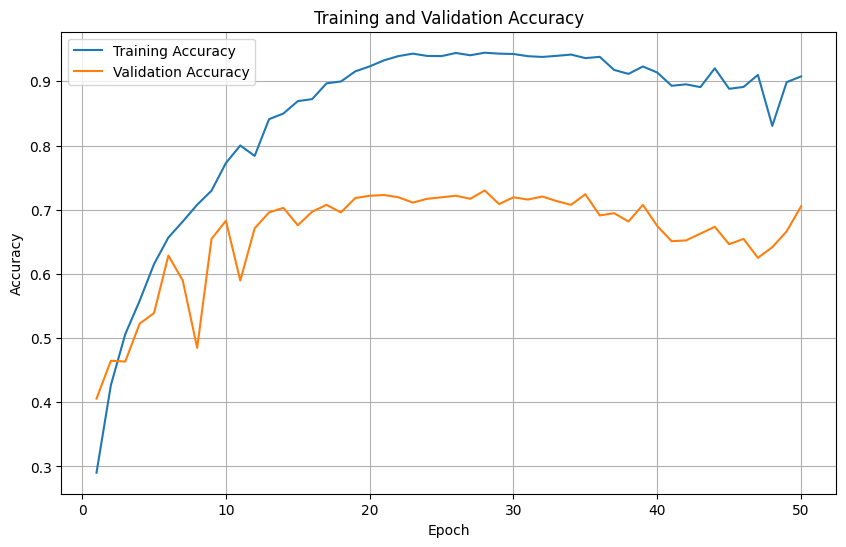

In [25]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
end_time = time.time()
calc_time(end_time, start_time)
utils.test_model(ctransformer_model, test_loader)

time to train model:   0.0 hours,   3.0 minutes,   4 seconds
Test acc: 0.625


In [27]:
torch.save(ctransformer_model, path_to_save+'ctransformer-400')
torch.cuda.empty_cache()
ctransformer_model.to('cpu')
del ctransformer_model
gc.collect()

357

### Data prep - 600

In [28]:
print('Prepping Training Data')
X_train3, y_train3 = data_prep(X_train, y_train, subsample, average, noise, 600)
print('\nPrepping Validation Data')
X_valid3, y_valid3 = data_prep(X_valid, y_valid, subsample, average, noise, 600)
print('\nPrepping Test Data')
X_test3 = test_data_prep(X_test, 600)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train3.shape)
print('Final shape of validation set:', X_valid3.shape)
print('Final shape of test set:', X_test3.shape)

train_loader = DataLoader(TensorDataset(X_train3, y_train3), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid3, y_valid3), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test3, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

Prepping Training Data
Shape of X after trimming: torch.Size([1903, 22, 600])
Shape of X after maxpooling: torch.Size([1903, 22, 300])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 300])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 300])
Shape of Y: torch.Size([7612])

Prepping Validation Data
Shape of X after trimming: torch.Size([212, 22, 600])
Shape of X after maxpooling: torch.Size([212, 22, 300])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 300])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 300])
Shape of Y: torch.Size([848])

Prepping Test Data
Shape of X after trimming: torch.Size([443, 22, 600])
Shape of X after maxpooling: torch.Size([443, 22, 300])

FINISHED PREP

Final shape of training set: torch.Size(

### shallow cnn - 600

In [29]:
torchinfo.summary(ctransformer.CTransformer(time_bins=600), input_size=(batch_size, 22, 200))

Layer (type:depth-idx)                        Output Shape              Param #
CTransformer                                  [200, 4]                  --
├─Sequential: 1-1                             [200, 25, 196]            --
│    └─Conv1d: 2-1                            [200, 25, 196]            2,775
│    └─ReLU: 2-2                              [200, 25, 196]            --
│    └─BatchNorm1d: 2-3                       [200, 25, 196]            50
│    └─Dropout: 2-4                           [200, 25, 196]            --
├─Sequential: 1-2                             [200, 200, 1, 57]         --
│    └─Conv2d: 2-5                            [200, 200, 1, 172]        125,200
│    └─ELU: 2-6                               [200, 200, 1, 172]        --
│    └─BatchNorm2d: 2-7                       [200, 200, 1, 172]        400
│    └─MaxPool2d: 2-8                         [200, 200, 1, 57]         --
│    └─Dropout: 2-9                           [200, 200, 1, 57]         --
├─Positiona

In [30]:
ctransformer_model = ctransformer.CTransformer(time_bins=600).to(device)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ctransformer_model.parameters(),
                              lr=0.001767340543208569,
                              betas=(0.9,0.999),
                              weight_decay=0.008272087903010924,
                              eps=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

In [32]:
start_time = time.time()
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=ctransformer_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=number_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.274, Train loss: 1.441
Val acc: 0.311, Val loss: 1.420

Epoch 2


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.343, Train loss: 1.331
Val acc: 0.380, Val loss: 1.402

Epoch 3


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.433, Train loss: 1.233
Val acc: 0.393, Val loss: 1.323

Epoch 4


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.487, Train loss: 1.152
Val acc: 0.443, Val loss: 1.294

Epoch 5


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.557, Train loss: 1.037
Val acc: 0.514, Val loss: 1.239

Epoch 6


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.607, Train loss: 0.948
Val acc: 0.559, Val loss: 1.191

Epoch 7


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.658, Train loss: 0.848
Val acc: 0.568, Val loss: 1.130

Epoch 8


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.674, Train loss: 0.812
Val acc: 0.584, Val loss: 1.213

Epoch 9


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.713, Train loss: 0.710
Val acc: 0.574, Val loss: 1.308

Epoch 10


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.723, Train loss: 0.691
Val acc: 0.592, Val loss: 1.257

Epoch 11


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.758, Train loss: 0.627
Val acc: 0.619, Val loss: 1.219

Epoch 12


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.773, Train loss: 0.581
Val acc: 0.632, Val loss: 1.182

Epoch 13


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.789, Train loss: 0.532
Val acc: 0.631, Val loss: 1.145

Epoch 14


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.818, Train loss: 0.464
Val acc: 0.620, Val loss: 1.256

Epoch 15


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.841, Train loss: 0.417
Val acc: 0.614, Val loss: 1.326

Epoch 16


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.843, Train loss: 0.404
Val acc: 0.637, Val loss: 1.222

Epoch 17


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.879, Train loss: 0.334
Val acc: 0.636, Val loss: 1.259

Epoch 18


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.890, Train loss: 0.298
Val acc: 0.640, Val loss: 1.441

Epoch 19


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.900, Train loss: 0.272
Val acc: 0.631, Val loss: 1.370

Epoch 20


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.900, Train loss: 0.266
Val acc: 0.654, Val loss: 1.356

Epoch 21


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.909, Train loss: 0.246
Val acc: 0.660, Val loss: 1.369

Epoch 22


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.914, Train loss: 0.230
Val acc: 0.654, Val loss: 1.365

Epoch 23


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.923, Train loss: 0.208
Val acc: 0.663, Val loss: 1.394

Epoch 24


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.921, Train loss: 0.208
Val acc: 0.660, Val loss: 1.407

Epoch 25


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.924, Train loss: 0.204
Val acc: 0.657, Val loss: 1.412

Epoch 26


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.923, Train loss: 0.206
Val acc: 0.664, Val loss: 1.413

Epoch 27


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.928, Train loss: 0.198
Val acc: 0.662, Val loss: 1.416

Epoch 28


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.926, Train loss: 0.198
Val acc: 0.660, Val loss: 1.444

Epoch 29


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.928, Train loss: 0.197
Val acc: 0.653, Val loss: 1.464

Epoch 30


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.925, Train loss: 0.201
Val acc: 0.660, Val loss: 1.511

Epoch 31


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.926, Train loss: 0.202
Val acc: 0.631, Val loss: 1.526

Epoch 32


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.919, Train loss: 0.209
Val acc: 0.611, Val loss: 1.628

Epoch 33


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.917, Train loss: 0.228
Val acc: 0.639, Val loss: 1.505

Epoch 34


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.911, Train loss: 0.238
Val acc: 0.645, Val loss: 1.475

Epoch 35


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.921, Train loss: 0.210
Val acc: 0.624, Val loss: 1.560

Epoch 36


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.897, Train loss: 0.272
Val acc: 0.660, Val loss: 1.419

Epoch 37


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.928, Train loss: 0.204
Val acc: 0.653, Val loss: 1.570

Epoch 38


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.923, Train loss: 0.208
Val acc: 0.600, Val loss: 1.682

Epoch 39


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.891, Train loss: 0.293
Val acc: 0.650, Val loss: 1.390

Epoch 40


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.905, Train loss: 0.254
Val acc: 0.631, Val loss: 1.390

Epoch 41


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.883, Train loss: 0.304
Val acc: 0.624, Val loss: 1.490

Epoch 42


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.900, Train loss: 0.265
Val acc: 0.631, Val loss: 1.536

Epoch 43


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.881, Train loss: 0.309
Val acc: 0.566, Val loss: 1.944

Epoch 44


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.796, Train loss: 0.541
Val acc: 0.639, Val loss: 1.339

Epoch 45


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.890, Train loss: 0.291
Val acc: 0.631, Val loss: 1.485

Epoch 46


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.898, Train loss: 0.275
Val acc: 0.605, Val loss: 1.610

Epoch 47


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.901, Train loss: 0.265
Val acc: 0.606, Val loss: 1.585

Epoch 48


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.846, Train loss: 0.396
Val acc: 0.587, Val loss: 1.531

Epoch 49


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.880, Train loss: 0.329
Val acc: 0.626, Val loss: 1.390

Epoch 50


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.919, Train loss: 0.228
Val acc: 0.638, Val loss: 1.603



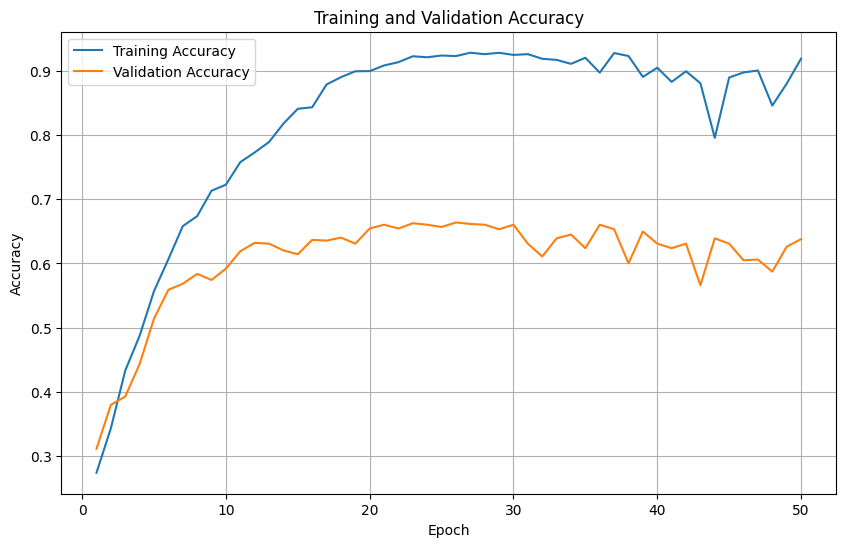

In [33]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
end_time = time.time()
calc_time(end_time, start_time)
utils.test_model(ctransformer_model, test_loader)

time to train model:   0.0 hours,   6.0 minutes,   35 seconds
Test acc: 0.582


In [35]:
torch.save(ctransformer_model, path_to_save+'ctransformer-600')
torch.cuda.empty_cache()
ctransformer_model.to('cpu')
del ctransformer_model
gc.collect()

3798

### Data prep - 800

In [36]:
print('Prepping Training Data')
X_train4, y_train4 = data_prep(X_train, y_train, subsample, average, noise, 800)
print('\nPrepping Validation Data')
X_valid4, y_valid4 = data_prep(X_valid, y_valid, subsample, average, noise, 800)
print('\nPrepping Test Data')
X_test4 = test_data_prep(X_test, 800)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train4.shape)
print('Final shape of validation set:', X_valid4.shape)
print('Final shape of test set:', X_test4.shape)

train_loader = DataLoader(TensorDataset(X_train4, y_train4), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid4, y_valid4), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test4, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

Prepping Training Data
Shape of X after trimming: torch.Size([1903, 22, 800])
Shape of X after maxpooling: torch.Size([1903, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 400])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 400])
Shape of Y: torch.Size([7612])

Prepping Validation Data
Shape of X after trimming: torch.Size([212, 22, 800])
Shape of X after maxpooling: torch.Size([212, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 400])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 400])
Shape of Y: torch.Size([848])

Prepping Test Data
Shape of X after trimming: torch.Size([443, 22, 800])
Shape of X after maxpooling: torch.Size([443, 22, 400])

FINISHED PREP

Final shape of training set: torch.Size(

### shallow cnn - 800

In [37]:
torchinfo.summary(ctransformer.CTransformer(time_bins=800), input_size=(batch_size, 22, 200))

Layer (type:depth-idx)                        Output Shape              Param #
CTransformer                                  [200, 4]                  --
├─Sequential: 1-1                             [200, 25, 196]            --
│    └─Conv1d: 2-1                            [200, 25, 196]            2,775
│    └─ReLU: 2-2                              [200, 25, 196]            --
│    └─BatchNorm1d: 2-3                       [200, 25, 196]            50
│    └─Dropout: 2-4                           [200, 25, 196]            --
├─Sequential: 1-2                             [200, 200, 1, 57]         --
│    └─Conv2d: 2-5                            [200, 200, 1, 172]        125,200
│    └─ELU: 2-6                               [200, 200, 1, 172]        --
│    └─BatchNorm2d: 2-7                       [200, 200, 1, 172]        400
│    └─MaxPool2d: 2-8                         [200, 200, 1, 57]         --
│    └─Dropout: 2-9                           [200, 200, 1, 57]         --
├─Positiona

In [38]:
ctransformer_model = ctransformer.CTransformer(time_bins=800).to(device)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ctransformer_model.parameters(),
                              lr=0.001767340543208569,
                              betas=(0.9,0.999),
                              weight_decay=0.008272087903010924,
                              eps=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

In [40]:
start_time = time.time()
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=ctransformer_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=number_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.283, Train loss: 1.446
Val acc: 0.300, Val loss: 1.425

Epoch 2


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.320, Train loss: 1.362
Val acc: 0.301, Val loss: 1.507

Epoch 3


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.393, Train loss: 1.289
Val acc: 0.274, Val loss: 1.564

Epoch 4


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.445, Train loss: 1.217
Val acc: 0.361, Val loss: 1.461

Epoch 5


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.519, Train loss: 1.098
Val acc: 0.407, Val loss: 1.400

Epoch 6


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.587, Train loss: 0.984
Val acc: 0.460, Val loss: 1.367

Epoch 7


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.633, Train loss: 0.898
Val acc: 0.518, Val loss: 1.319

Epoch 8


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.648, Train loss: 0.852
Val acc: 0.456, Val loss: 1.590

Epoch 9


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.702, Train loss: 0.748
Val acc: 0.547, Val loss: 1.356

Epoch 10


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.707, Train loss: 0.735
Val acc: 0.519, Val loss: 1.465

Epoch 11


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.756, Train loss: 0.640
Val acc: 0.540, Val loss: 1.370

Epoch 12


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.765, Train loss: 0.598
Val acc: 0.568, Val loss: 1.340

Epoch 13


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.792, Train loss: 0.528
Val acc: 0.578, Val loss: 1.395

Epoch 14


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.832, Train loss: 0.456
Val acc: 0.612, Val loss: 1.292

Epoch 15


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.825, Train loss: 0.468
Val acc: 0.625, Val loss: 1.286

Epoch 16


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.844, Train loss: 0.409
Val acc: 0.626, Val loss: 1.372

Epoch 17


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.871, Train loss: 0.339
Val acc: 0.653, Val loss: 1.353

Epoch 18


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.878, Train loss: 0.323
Val acc: 0.642, Val loss: 1.359

Epoch 19


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.897, Train loss: 0.279
Val acc: 0.614, Val loss: 1.607

Epoch 20


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.904, Train loss: 0.264
Val acc: 0.618, Val loss: 1.549

Epoch 21


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.913, Train loss: 0.234
Val acc: 0.631, Val loss: 1.551

Epoch 22


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.923, Train loss: 0.215
Val acc: 0.624, Val loss: 1.544

Epoch 23


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.921, Train loss: 0.215
Val acc: 0.624, Val loss: 1.575

Epoch 24


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.924, Train loss: 0.207
Val acc: 0.618, Val loss: 1.583

Epoch 25


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.928, Train loss: 0.199
Val acc: 0.629, Val loss: 1.586

Epoch 26


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.927, Train loss: 0.198
Val acc: 0.624, Val loss: 1.594

Epoch 27


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.928, Train loss: 0.197
Val acc: 0.630, Val loss: 1.581

Epoch 28


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.923, Train loss: 0.207
Val acc: 0.620, Val loss: 1.599

Epoch 29


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.923, Train loss: 0.203
Val acc: 0.627, Val loss: 1.642

Epoch 30


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.929, Train loss: 0.194
Val acc: 0.640, Val loss: 1.590

Epoch 31


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.930, Train loss: 0.189
Val acc: 0.629, Val loss: 1.622

Epoch 32


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.930, Train loss: 0.188
Val acc: 0.634, Val loss: 1.726

Epoch 33


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.927, Train loss: 0.204
Val acc: 0.639, Val loss: 1.615

Epoch 34


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.924, Train loss: 0.208
Val acc: 0.642, Val loss: 1.645

Epoch 35


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.922, Train loss: 0.213
Val acc: 0.629, Val loss: 1.629

Epoch 36


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.920, Train loss: 0.217
Val acc: 0.567, Val loss: 1.929

Epoch 37


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.894, Train loss: 0.272
Val acc: 0.637, Val loss: 1.603

Epoch 38


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.912, Train loss: 0.229
Val acc: 0.574, Val loss: 2.000

Epoch 39


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.882, Train loss: 0.312
Val acc: 0.624, Val loss: 1.547

Epoch 40


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.894, Train loss: 0.279
Val acc: 0.623, Val loss: 1.713

Epoch 41


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.912, Train loss: 0.242
Val acc: 0.613, Val loss: 1.866

Epoch 42


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.923, Train loss: 0.201
Val acc: 0.593, Val loss: 1.877

Epoch 43


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.904, Train loss: 0.262
Val acc: 0.591, Val loss: 1.737

Epoch 44


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.908, Train loss: 0.250
Val acc: 0.546, Val loss: 2.018

Epoch 45


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.907, Train loss: 0.246
Val acc: 0.636, Val loss: 1.614

Epoch 46


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.921, Train loss: 0.220
Val acc: 0.561, Val loss: 2.073

Epoch 47


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.894, Train loss: 0.288
Val acc: 0.626, Val loss: 1.547

Epoch 48


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.905, Train loss: 0.255
Val acc: 0.626, Val loss: 1.637

Epoch 49


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.899, Train loss: 0.265
Val acc: 0.580, Val loss: 1.799

Epoch 50


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.886, Train loss: 0.318
Val acc: 0.568, Val loss: 1.720



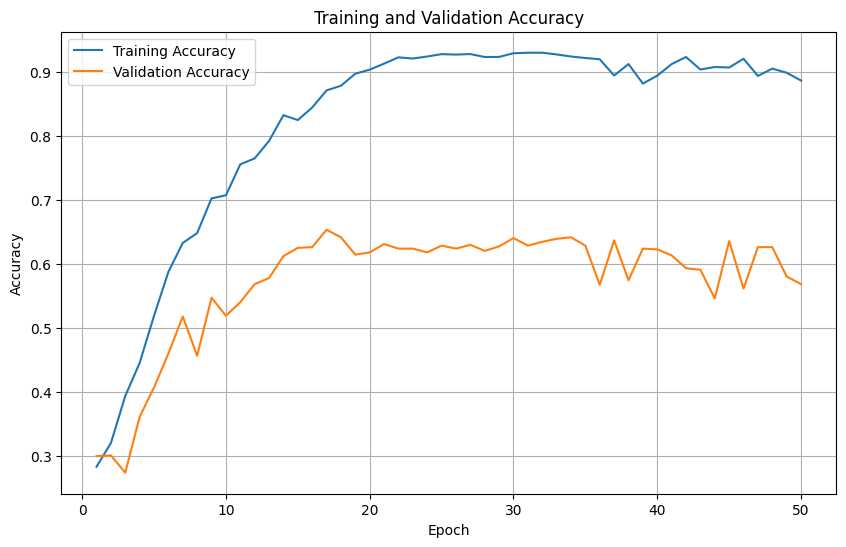

In [41]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
end_time = time.time()
calc_time(end_time, start_time)
utils.test_model(ctransformer_model, test_loader)

time to train model:   0.0 hours,   11.0 minutes,   58 seconds
Test acc: 0.655


In [43]:
torch.save(ctransformer_model, path_to_save+'ctransformer-800')
torch.cuda.empty_cache()
ctransformer_model.to('cpu')
del ctransformer_model
gc.collect()

3778

### Data prep - 1000

In [44]:
print('Prepping Training Data')
X_train5, y_train5 = data_prep(X_train, y_train, subsample, average, noise, 1000)
print('\nPrepping Validation Data')
X_valid5, y_valid5 = data_prep(X_valid, y_valid, subsample, average, noise, 1000)
print('\nPrepping Test Data')
X_test5 = test_data_prep(X_test, 1000)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train5.shape)
print('Final shape of validation set:', X_valid5.shape)
print('Final shape of test set:', X_test5.shape)

train_loader = DataLoader(TensorDataset(X_train5, y_train5), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid5, y_valid5), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test5, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

Prepping Training Data
Shape of X after trimming: torch.Size([1903, 22, 1000])
Shape of X after maxpooling: torch.Size([1903, 22, 500])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 500])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 500])
Shape of Y: torch.Size([7612])

Prepping Validation Data
Shape of X after trimming: torch.Size([212, 22, 1000])
Shape of X after maxpooling: torch.Size([212, 22, 500])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 500])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 500])
Shape of Y: torch.Size([848])

Prepping Test Data
Shape of X after trimming: torch.Size([443, 22, 1000])
Shape of X after maxpooling: torch.Size([443, 22, 500])

FINISHED PREP

Final shape of training set: torch.Si

### shallow cnn - 1000

In [45]:
torchinfo.summary(ctransformer.CTransformer(time_bins=1000), input_size=(batch_size, 22, 200))

Layer (type:depth-idx)                        Output Shape              Param #
CTransformer                                  [200, 4]                  --
├─Sequential: 1-1                             [200, 25, 196]            --
│    └─Conv1d: 2-1                            [200, 25, 196]            2,775
│    └─ReLU: 2-2                              [200, 25, 196]            --
│    └─BatchNorm1d: 2-3                       [200, 25, 196]            50
│    └─Dropout: 2-4                           [200, 25, 196]            --
├─Sequential: 1-2                             [200, 200, 1, 57]         --
│    └─Conv2d: 2-5                            [200, 200, 1, 172]        125,200
│    └─ELU: 2-6                               [200, 200, 1, 172]        --
│    └─BatchNorm2d: 2-7                       [200, 200, 1, 172]        400
│    └─MaxPool2d: 2-8                         [200, 200, 1, 57]         --
│    └─Dropout: 2-9                           [200, 200, 1, 57]         --
├─Positiona

In [46]:
ctransformer_model = ctransformer.CTransformer(time_bins=1000).to(device)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ctransformer_model.parameters(),
                              lr=0.001767340543208569,
                              betas=(0.9,0.999),
                              weight_decay=0.008272087903010924,
                              eps=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

In [48]:
start_time = time.time()
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=ctransformer_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=number_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.248, Train loss: 1.444
Val acc: 0.250, Val loss: 1.406

Epoch 2


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.273, Train loss: 1.397
Val acc: 0.270, Val loss: 1.391

Epoch 3


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.328, Train loss: 1.356
Val acc: 0.337, Val loss: 1.342

Epoch 4


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.428, Train loss: 1.243
Val acc: 0.423, Val loss: 1.441

Epoch 5


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.480, Train loss: 1.159
Val acc: 0.447, Val loss: 1.255

Epoch 6


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.531, Train loss: 1.088
Val acc: 0.505, Val loss: 1.172

Epoch 7


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.597, Train loss: 0.972
Val acc: 0.553, Val loss: 1.188

Epoch 8


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.634, Train loss: 0.899
Val acc: 0.561, Val loss: 1.057

Epoch 9


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.676, Train loss: 0.812
Val acc: 0.621, Val loss: 1.007

Epoch 10


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.712, Train loss: 0.741
Val acc: 0.606, Val loss: 1.158

Epoch 11


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.735, Train loss: 0.682
Val acc: 0.616, Val loss: 1.109

Epoch 12


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.770, Train loss: 0.590
Val acc: 0.651, Val loss: 1.069

Epoch 13


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.760, Train loss: 0.599
Val acc: 0.663, Val loss: 1.141

Epoch 14


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.794, Train loss: 0.529
Val acc: 0.646, Val loss: 1.108

Epoch 15


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.814, Train loss: 0.493
Val acc: 0.665, Val loss: 1.096

Epoch 16


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.839, Train loss: 0.423
Val acc: 0.657, Val loss: 1.235

Epoch 17


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.844, Train loss: 0.404
Val acc: 0.690, Val loss: 1.191

Epoch 18


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.869, Train loss: 0.353
Val acc: 0.647, Val loss: 1.280

Epoch 19


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.870, Train loss: 0.349
Val acc: 0.640, Val loss: 1.208

Epoch 20


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.883, Train loss: 0.310
Val acc: 0.662, Val loss: 1.247

Epoch 21


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.891, Train loss: 0.289
Val acc: 0.638, Val loss: 1.355

Epoch 22


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.896, Train loss: 0.281
Val acc: 0.644, Val loss: 1.286

Epoch 23


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.902, Train loss: 0.261
Val acc: 0.642, Val loss: 1.312

Epoch 24


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.903, Train loss: 0.255
Val acc: 0.659, Val loss: 1.295

Epoch 25


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.911, Train loss: 0.244
Val acc: 0.658, Val loss: 1.321

Epoch 26


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.911, Train loss: 0.243
Val acc: 0.654, Val loss: 1.321

Epoch 27


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.911, Train loss: 0.246
Val acc: 0.653, Val loss: 1.309

Epoch 28


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.913, Train loss: 0.239
Val acc: 0.658, Val loss: 1.329

Epoch 29


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.908, Train loss: 0.249
Val acc: 0.652, Val loss: 1.333

Epoch 30


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.908, Train loss: 0.243
Val acc: 0.650, Val loss: 1.347

Epoch 31


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.908, Train loss: 0.251
Val acc: 0.657, Val loss: 1.363

Epoch 32


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.908, Train loss: 0.250
Val acc: 0.637, Val loss: 1.415

Epoch 33


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.901, Train loss: 0.257
Val acc: 0.644, Val loss: 1.385

Epoch 34


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.915, Train loss: 0.235
Val acc: 0.636, Val loss: 1.504

Epoch 35


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.888, Train loss: 0.297
Val acc: 0.627, Val loss: 1.434

Epoch 36


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.899, Train loss: 0.271
Val acc: 0.631, Val loss: 1.344

Epoch 37


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.886, Train loss: 0.309
Val acc: 0.639, Val loss: 1.393

Epoch 38


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.905, Train loss: 0.252
Val acc: 0.656, Val loss: 1.336

Epoch 39


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.910, Train loss: 0.244
Val acc: 0.642, Val loss: 1.584

Epoch 40


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.867, Train loss: 0.351
Val acc: 0.653, Val loss: 1.325

Epoch 41


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.902, Train loss: 0.266
Val acc: 0.614, Val loss: 1.707

Epoch 42


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.893, Train loss: 0.298
Val acc: 0.552, Val loss: 1.909

Epoch 43


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.847, Train loss: 0.414
Val acc: 0.664, Val loss: 1.433

Epoch 44


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.878, Train loss: 0.328
Val acc: 0.613, Val loss: 1.591

Epoch 45


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.884, Train loss: 0.314
Val acc: 0.614, Val loss: 1.660

Epoch 46


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.881, Train loss: 0.327
Val acc: 0.601, Val loss: 1.695

Epoch 47


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.901, Train loss: 0.264
Val acc: 0.649, Val loss: 1.476

Epoch 48


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.906, Train loss: 0.256
Val acc: 0.618, Val loss: 1.828

Epoch 49


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.891, Train loss: 0.293
Val acc: 0.631, Val loss: 1.534

Epoch 50


  0%|          | 0/39 [00:00<?, ?it/s]

Train acc: 0.917, Train loss: 0.224
Val acc: 0.612, Val loss: 1.721



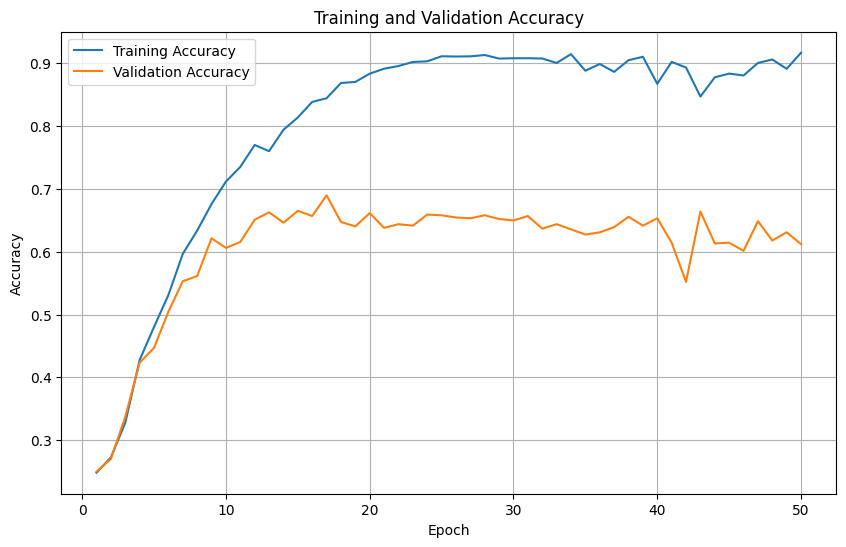

In [49]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
end_time = time.time()
calc_time(end_time, start_time)
utils.test_model(ctransformer_model, test_loader)

time to train model:   0.0 hours,   19.0 minutes,   32 seconds
Test acc: 0.594


In [51]:
torch.save(ctransformer_model, path_to_save+'ctransformer-1000')
torch.cuda.empty_cache()
ctransformer_model.to('cpu')
del ctransformer_model
gc.collect()

323

# **end of party**

In [52]:
print('time i will never get back:')
hours = (end_time - super_start_time) // 3600
minutes = ((end_time - super_start_time) % 3600) // 60
seconds = (end_time - super_start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

time i will never get back:
time to train models: 0.0 hours, 19.0 minutes, 32 seconds
